In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# ============================
df = pd.read_csv("frequency_cleaned.csv")

def get_top_stations(direction, time_col, top_n=20):
    subset = df[df["Direction"] == direction]
    top = subset.sort_values(by=time_col, ascending=False).head(top_n)
    return set(top["ATC_STATION_NO"].astype(str))

baskets = {
    "EAST_AM": get_top_stations("EAST", "One-way flow at AM peak hour"),
    "EAST_PM": get_top_stations("EAST", "One-way flow at PM peak hour"),
    "WEST_AM": get_top_stations("WEST", "One-way flow at AM peak hour"),
    "WEST_PM": get_top_stations("WEST", "One-way flow at PM peak hour"),
}


# one-hot ============================
transactions = list(baskets.values())
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_basket = pd.DataFrame(te_ary, columns=te.columns_)

# ============================
# fpgrowth）
# ============================
frequent_itemsets = fpgrowth(df_basket, min_support=0.5, use_colnames=True, max_len=2)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules["interest"] = abs(rules["confidence"] - rules["consequent support"])

print("📋 Association Rules (sorted by interest):")
print(rules[["antecedents", "consequents", "support", "confidence", "interest"]])


# ===========
cooccur = pd.DataFrame(0, index=df_basket.columns, columns=df_basket.columns)
for row in df_basket.values:
    present = [item for item, flag in zip(df_basket.columns, row) if flag]
    for a, b in combinations(present, 2):
        cooccur.at[a, b] += 1
        cooccur.at[b, a] += 1

pink_gradient = LinearSegmentedColormap.from_list("pink_gradient", ["#F7D4DC", "#FF1278"])

cooccur_freq = cooccur / len(df_basket)

mask = np.triu(np.ones_like(cooccur_freq, dtype=bool))

plt.rcParams['font.family'] = 'DejaVu Serif' 

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cooccur_freq,
            mask=mask,
            cmap=pink_gradient,
            annot=False,
            cbar=True,
            linewidths=0.5,
            linecolor='white',
            vmin=0.0, vmax=1.0,
            ax=ax,
            cbar_kws={"shrink": 0.6})

ax.set_title("High-Frequency Station Co-occurrence Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("cooccurrence_heatmap.pdf", format="pdf")
plt.close()

print(" Heatmap saved as cooccurrence_heatmap.pdf")




/root/miniconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


📋 Association Rules (sorted by interest):
    antecedents consequents  support  confidence  interest
0        (5026)      (5030)      1.0         1.0       0.0
1        (5030)      (5026)      1.0         1.0       0.0
2        (5025)      (5026)      1.0         1.0       0.0
3        (5026)      (5025)      1.0         1.0       0.0
4        (5025)      (5030)      1.0         1.0       0.0
..          ...         ...      ...         ...       ...
335      (1001)      (5012)      0.5         1.0       0.0
336      (1001)      (5001)      0.5         1.0       0.0
337      (1001)      (5025)      0.5         1.0       0.0
338      (1001)      (5026)      0.5         1.0       0.0
339      (1001)      (5030)      0.5         1.0       0.0

[340 rows x 5 columns]
✅ Heatmap saved as cooccurrence_heatmap.pdf


In [10]:
import pandas as pd
import numpy as np
from itertools import combinations
import plotly.graph_objects as go

#  df_basket（one-hot : DataFrame，each line is a point）
# sample
# df_basket = pd.DataFrame([[1, 0, 1], [0, 1, 1]], columns=['1001', '1002', '1003'])

cooccur = pd.DataFrame(0, index=df_basket.columns, columns=df_basket.columns)
for row in df_basket.values:
    present = [item for item, flag in zip(df_basket.columns, row) if flag]
    for a, b in combinations(present, 2):
        cooccur.at[a, b] += 1
        cooccur.at[b, a] += 1

cooccur_freq = cooccur / len(df_basket)

cooccur_masked = cooccur_freq.copy()
for i in range(cooccur_masked.shape[0]):
    for j in range(i + 1, cooccur_masked.shape[1]):
        cooccur_masked.iat[i, j] = np.nan

fig = go.Figure(data=go.Heatmap(
    z=cooccur_masked.values,
    x=cooccur_masked.columns,
    y=cooccur_masked.index,
    colorscale=[[0, "#F7D4DC"], [1, "#FF1278"]],
    zmin=0,
    zmax=1,
    hovertemplate='Station 1: %{y}<br>Station 2: %{x}<br>Frequency: %{z:.2f}<extra></extra>',
    showscale=True,
    colorbar=dict(title="Co-occurrence", thickness=10)  
))

fig.update_layout(
    title="High-Frequency Station Co-occurrence Heatmap (Interactive)",
    font=dict(family="DejaVu Serif", size=14),
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis=dict(tickangle=45),
)

fig.write_html("cooccurrence_heatmap_interactive.html")
print("✅ 已保存为 cooccurrence_heatmap_interactive.html")



✅ 已保存为 cooccurrence_heatmap_interactive.html


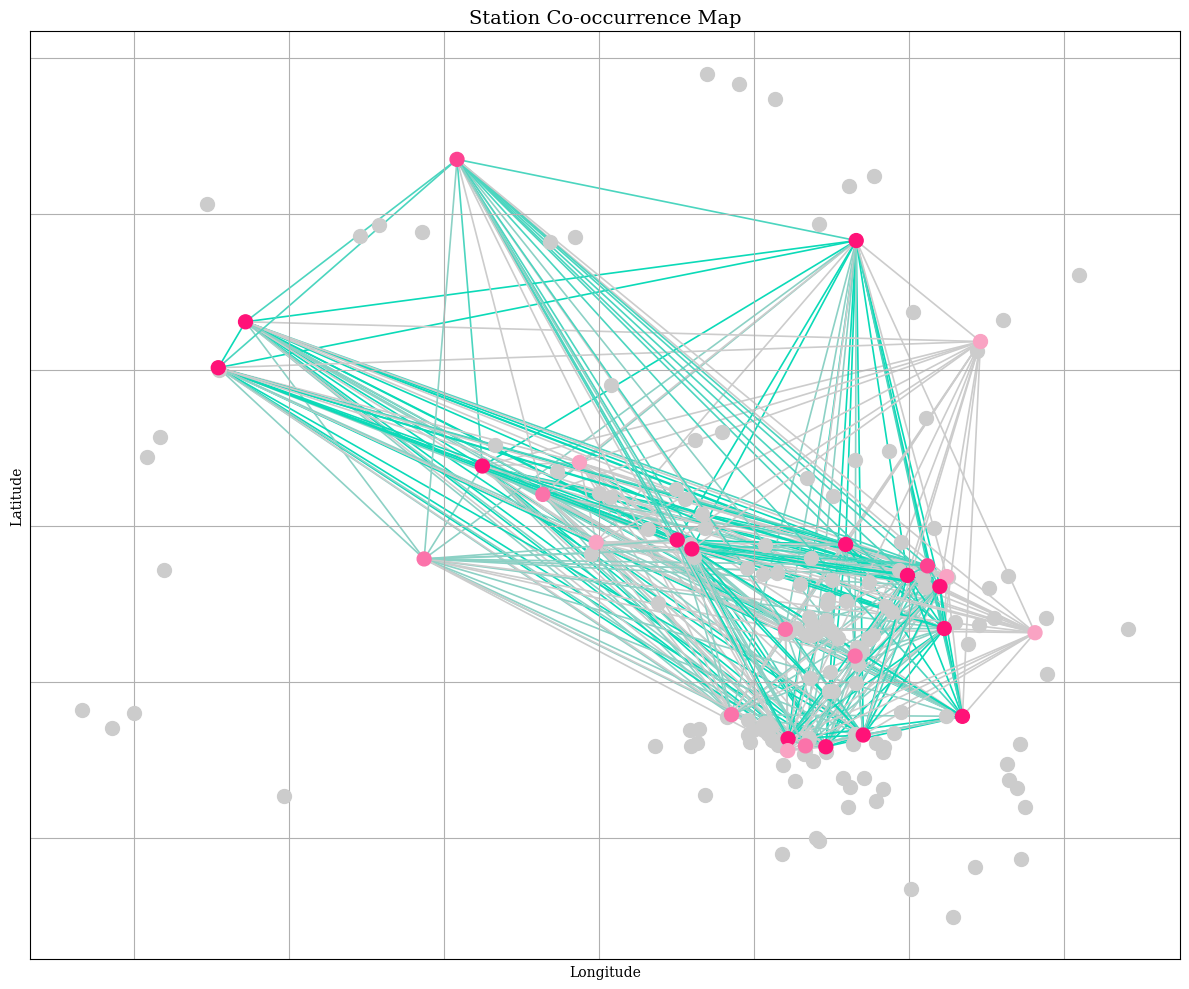

In [17]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = pd.read_csv("frequency_cleaned.csv")

def get_top_stations(direction, time_col, top_n=20):
    subset = df[df["Direction"] == direction]
    top = subset.sort_values(by=time_col, ascending=False).head(top_n)
    return set(top["ATC_STATION_NO"].astype(str))

baskets = {
    "EAST_AM": get_top_stations("EAST", "One-way flow at AM peak hour"),
    "EAST_PM": get_top_stations("EAST", "One-way flow at PM peak hour"),
    "WEST_AM": get_top_stations("WEST", "One-way flow at AM peak hour"),
    "WEST_PM": get_top_stations("WEST", "One-way flow at PM peak hour"),
}

edges = {}
node_counts = {}
for basket in baskets.values():
    for a, b in combinations(sorted(basket), 2):
        edges[(a, b)] = edges.get((a, b), 0) + 1
        node_counts[a] = node_counts.get(a, 0) + 1
        node_counts[b] = node_counts.get(b, 0) + 1

station_coords = df.drop_duplicates(subset="ATC_STATION_NO").set_index("ATC_STATION_NO")[["Latitude", "Longitude"]].astype(float)
all_nodes = set(station_coords.index.astype(str))

G = nx.Graph()
for node in all_nodes:
    lat, lon = station_coords.loc[int(node)]
    G.add_node(node, pos=(lon, lat))

for (a, b), weight in edges.items():
    G.add_edge(a, b, weight=weight)

heatmap_cmap = LinearSegmentedColormap.from_list("pink_gradient", ["#F7D4DC", "#FF1278"])
edge_cmap = LinearSegmentedColormap.from_list("edge_cmap", ["#cccccc", "#0BDAB8"])

# normalization
node_max = max(node_counts.values()) if node_counts else 1
pos = nx.get_node_attributes(G, 'pos')

common_nodes = [node for node in G.nodes() if node in node_counts]
unused_nodes = [node for node in G.nodes() if node not in node_counts]

edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
if len(edge_weights) > 0:
    norm_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min() + 1e-6)
    edge_colors = [edge_cmap(w) for w in norm_weights]
else:
    edge_colors = []

plt.figure(figsize=(12, 10))

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.2)

nx.draw_networkx_nodes(G, pos,
                       nodelist=unused_nodes,
                       node_color="#cccccc",
                       node_size=100)

nx.draw_networkx_nodes(G, pos,
                       nodelist=common_nodes,
                       node_color=[heatmap_cmap(node_counts[n] / node_max) for n in common_nodes],
                       node_size=100)

plt.title("Station Co-occurrence Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.savefig("cooccurrence_map_optimized.pdf", format="pdf")
plt.show()